<a id='head'></a>
# Table of Contents
* [0. Models importing](#import)
    * [0.1 Helpful functions](#funcs)
* [1. Arguments loading](#args)
* [2. RUN](#run)
    * [2.1 Runner 1](#runner_1)
    * [2.2 Runner 2](#runner_2)
        * [2.1.1 Initialisation](#init)
        * [2.1.2 Run](#run_)
* [3. Save results](#save)
* [4. Plots](#plots)

<a id='import'></a>
# 0. Models importing<sup>[head](#head)</sup>

In [127]:
%run Models.ipynb

<a id='funcs'></a>
## 0.1 Helpful functions<sup>[head](#head)</sup>

In [ ]:
def preprocessor(batchfile_path, input_state, arr_period, alpha=1, tail_length=-1):
    trace = []
    whole_trace = pd.read_table(batchfile_path, header = None).values.flatten()

    if input_state[0] >= 0:
        trace = []
        trace.append(input_state[1])
        h = input_state[0] - arr_period
        n = input_state[2] + 1
        while h >= 0:
            trace.append(whole_trace[n])
            h -= arr_period
            n +=1
    else:
        trace = []
        
    sent_trace = whole_trace[:input_state[2] - 1].tolist() + trace
            
    input_distr_dict, input_distr, cond_probs = distributor(sent_trace, alpha)
    
    problist = Counter()
    lostlist = Counter()
    arr_list = Counter()
    if input_state[0] >= 0:
        problist = {(0, input_state[0], input_state[1], input_state[2]) : 1} #0 because we know trace
        lostlist = {(0, input_state[0], input_state[1], input_state[2]) : 0} #0 because we know trace
        arr_list = {(0, input_state[0], input_state[1], input_state[2]) : 0} #0 because we know trace
    else:
        for size, prob in input_distr_dict.items():
            problist += {(1, input_state[0], size, size) : prob}
            lostlist += {(1, input_state[0], size, size) : 0}
            arr_list += {(1, input_state[0], size, size) : 0}
    
    return trace, input_distr_dict, input_distr, cond_probs, problist, lostlist, arr_list

def distributor(trace, alpha, tail_length=-1, n=-1):
    if tail_length != -1:
        if n != -1:
            tail_trace = trace[n - tail_length:n]
        else:
            tail_trace = trace[- tail_length:]
    else:
        if n != -1:
            tail_trace = trace[:n]
        else:
            tail_trace = trace
            
    tail_trace = tail_trace[::-1] #Развернуть для удобного подсчёта распределения
    max_size = max(tail_trace)
    input_distr_dict = Counter()
    input_distr = np.zeros(max_size + 1)
    cond_probs = np.zeros((max_size + 1, max_size + 1))
    
    ###Получение распределений
    for i in range(len(tail_trace)):
        input_distr_dict[tail_trace[i]] += alpha ** i
        input_distr[tail_trace[i]] += alpha ** i
    
    for i in range(len(tail_trace) - 1):
        cond_probs[tail_trace[i+1], tail_trace[i]] += alpha ** i
    
    ###########Нормировка##############################################3
    ###матрицы условных вероятностей
    for i in range(1, max_size + 1):
        line_sum = np.sum(cond_probs[i])
        if line_sum == 0:
            cond_probs[i, 0] = 1
        else:
            cond_probs[i] = cond_probs[i] / line_sum
    ###словаря с распределением
    summa = sum(input_distr_dict.values())
    for batch_size, prob in input_distr_dict.items():
        input_distr_dict[batch_size] /= summa
    ###массива с распределением
    input_distr = input_distr / np.sum(input_distr)
            
    return input_distr_dict, input_distr, cond_probs

def refresh_input(dictionary, input_file='input.txt'):
    file = open(input_file, 'w')
    for key,value in dictionary.items():
        file.write(key + ' ' + str(value) + '\n')
    file.close()
    
def init_dict(args_dict, seed=args_dict['seed'], current_age=0, current_size=0, batch_index=0, window_size=50000):
    new_dict = {"seed": seed,
                 "res_period" : 10,
                 "arr_period" : args_dict['arr_period'],
                 "batchfile_path" : args_dict['batchfile_path'],
                 "delay_bound" : args_dict['delay_bound'],
                 "det_per" : args_dict['det_per'],
                 "ran_per" : args_dict['ran_per'],
                 "window_size" : window_size,
                 "rand_tx_duration" : args_dict['rand_tx_duration'],
                 "det_tx_duration" : args_dict['det_tx_duration'],
                 "mean_access_time" : args_dict['mean_access_time'],
                 "max_batch_size" : args_dict['max_batch_size'],
                 "random_on" : args_dict['random_on'],
                 "current_age" : current_age,
                 "current_size" : current_size,
                 "batch_index" : batch_index}
    return new_dict

<a id='args'></a>
# 1. Arguments loading<sup>[head](#head)</sup>

In [ ]:
number_of_windows = 20
ana_plr = [0]
sim_plr = []
TRES = []
ana1_plr = [0]
sim1_plr = []
TRES1 = []
ana2_plr = [0]
sim2_plr = []
TRES2 = []
res_period_array = [1,2,3,4,5,6,7,8,9,10,12,14,16,18,20,25,30,35]
#init_res_period = 35

input_file = 'input.txt'
target_plr = 0.0001

params = {}
params['model_name'] = 'TXOP'
params['model_type'] = 'ana'
params['block_size'] = 1
params['seed'] = 1
params['arr_period'] = args_dict['arr_period']
params['delay_bound'] = args_dict['delay_bound']
params['per'] = args_dict['det_per']

<a id='run'></a>
# 2. RUN<sup>[head](#head)</sup>

<a id='runner_1'></a>
## 2.1 Runner 1<sup>[head](#head)</sup>

In [254]:
def run1(model_name, number_of_windows, write_to_file=False, res_periods=res_period_array,
        input_file=input_file, target_plr=target_plr, output_folder='results/'):
    ana_plr = [0]
    sim_plr = []
    TRES = []
    length = len(res_periods)
    
    for it in range(number_of_windows):
        sim_model = SimulationModel(input_file=input_file)
        args_dict, PLR_sim = sim_model()

        input_state = (args_dict['current_age'], args_dict['current_size'], args_dict['batch_index'])

        TRES.append(args_dict['res_period'])
        sim_plr.append(PLR_sim)

        trace, input_distr_dict, input_distr, cond_probs, statesproba, stateslost, statesarrived = preprocessor(args_dict['batchfile_path'], input_state, args_dict['arr_period'])
        
        outname = str(args_dict['seed']) + '-' + str(args_dict['window_size']) + '-' + str(number_of_windows) + '-' + str(args_dict['batchfile_path'])
        outname_final = 'final-' + outname
        if write_to_file:
            f = open(output_folder + outname, "a")
            f.write("sim\t{0}\t{1}\t{2}\n".format(it, args_dict['res_period'], PLR_sim))
        else:
            print('sim', it, args_dict['res_period'], PLR_sim)        
            
        #for binary search
        left_index = 0
        right_index = length - 1
        index = length - 1
        res_period = res_periods[length - 1]
        #index_prev = lrngth - 1
        plr_prev = 1
        plr = 1
        while (1):
            assert(res_period > 0)
            if model_name == 'Dynamic':
                tracer = BaseTracer(args_dict['arr_period'], res_period,
                                    args_dict['delay_bound'], args_dict['det_per'])
                tracer.reset(trace, statesproba, stateslost, statesarrived, input_distr_dict)
                plr = tracer(args_dict['window_size'], verbose=2, report_period=100000, min_tracked_proba=1e-8)
            else:
                params['input_distr'] = input_distr
                params['res_period'] = res_period
                params['cond_probs'] = cond_probs
                if model_name == '(h,m)':
                    PLR = BurstyVbrOrderedModel_hm(params)
                else:
                    assert model_name == '(h,m,n)'
                    PLR = BurstyVbrOrderedModel_hmn(params)
                plr = PLR()
            if write_to_file:
                f.write('{0}\t{1}\t{2}\t{3}'.format(model_name, it, res_period, plr))
            else:
                print(model_name, it, res_period, plr)   
                
            #if plr > 1:
            #    raise ValueError("eptahule")
            if plr <= target_plr:
                if index == right_index:
                    ana_plr.append(plr)
                    break
                else:
                    left_index = index
                    if left_index + 1 == right_index:
                        ana_plr.append(plr)
                        break
                    else:
                        plr_prev = plr
                        index = int(np.floor((right_index + left_index) / 2))
                        res_period = res_periods[index]
            else:
                if index == 0:
                    ana_plr.append(plr)
                    break
                right_index = index
                if left_index + 1 == right_index:
                    res_period = res_periods[left_index]
                    ana_plr.append(plr_prev)
                    break
                else:
                    plr_prev = plr
                    index = int(np.floor((right_index + left_index) / 2))
                    res_period = res_periods[index]

        args_dict['res_period'] = res_period
        refresh_input(args_dict, input_file=input_file)
                    
                    
    sim_model = SimulationModel(input_file=input_file)
    args_dict, PLR_sim = sim_model()
    
    if write_to_file:
        f.write("sim\t{0}\t{1}\t{2}\n".format(it, args_dict['res_period'], PLR_sim))
        f.close()
    else:
        print('sim', it, args_dict['res_period'], PLR_sim)
    
    
    if write_to_file:
        with open(outfolder + final_outname,"w") as f1:
            for i in range(len(sim_plr)):
                f.write("{0}\t{1}\t{2}\n".format(ana[i],sim[i],tres[i]))
        f1.close()

    dictionary = init_dict(args_dict)
    refresh_input(dictionary, input_file=input_file)
    
    return ana_plr, sim_plr, TRES

<a id='runner_2'></a>
## 2.2 Runner 2<sup>[head](#head)</sup>

In [ ]:
def binary_searcher(res_periods, plr, target_plr):
    length = len(res_periods)
    left_index = 0
    right_index = length - 1
    index = length - 1
    res_period = res_periods[length - 1]
    plr_prev = 1


def run_2(model_name, number_of_windows, write_to_file=False, res_periods=res_period_array,
        input_file=input_file, target_plr=target_plr, output_folder='results/'):
    ana_plr = []
    sim_plr = []
    sim_plr_ideal = []
    TRES = []
    
    #Набор статистики
    sim_model = SimulationModel(input_file=input_file)
    args_dict, PLR_sim = sim_model()
    
    #Прогон по окнам
    for it in range(number_of_windows):
        input_state = (args_dict['current_age'], args_dict['current_size'], args_dict['batch_index'])

        

        trace, input_distr_dict, input_distr, cond_probs, statesproba, stateslost, statesarrived = preprocessor(args_dict['batchfile_path'], input_state, args_dict['arr_period'])
        
        outname = str(args_dict['seed']) + '-' + str(args_dict['window_size']) + '-' + str(number_of_windows) + '-' + str(args_dict['batchfile_path'])
        outname_final = 'final-' + outname
        if write_to_file:
            f = open(output_folder + outname, "a")
            f.write("sim\t{0}\t{1}\t{2}\n".format(it, args_dict['res_period'], PLR_sim))
        else:
            print('sim', it, args_dict['res_period'], PLR_sim)        
            
        #for binary search
        length = len(res_periods)
        left_index = 0
        right_index = length - 1
        index = length - 1
        res_period = res_periods[length - 1]
        plr_prev = 1
        plr = 1
        
        #Прогон аналитики + поиск оптимального T_res
        while (1):
            assert(res_period > 0)
            if model_name == 'Dynamic':
                tracer = BaseTracer(args_dict['arr_period'], res_period,
                                    args_dict['delay_bound'], args_dict['det_per'])
                tracer.reset(trace, statesproba, stateslost, statesarrived, input_distr_dict)
                plr = tracer(args_dict['window_size'], verbose=2, report_period=100000, min_tracked_proba=1e-8)
            else:
                params['input_distr'] = input_distr
                params['res_period'] = res_period
                params['cond_probs'] = cond_probs
                if model_name == '(h,m)':
                    PLR = BurstyVbrOrderedModel_hm(params)
                else:
                    assert model_name == '(h,m,n)'
                    PLR = BurstyVbrOrderedModel_hmn(params)
                plr = PLR()
            if write_to_file:
                f.write('{0}\t{1}\t{2}\t{3}'.format(model_name, it, res_period, plr))
            else:
                print(model_name, it, res_period, plr)   
                
            #if plr > 1:
            #    raise ValueError("eptahule")
            if plr <= target_plr:
                if index == right_index:
                    ana_plr.append(plr)
                    break
                else:
                    left_index = index
                    if left_index + 1 == right_index:
                        ana_plr.append(plr)
                        break
                    else:
                        plr_prev = plr
                        index = int(np.floor((right_index + left_index) / 2))
                        res_period = res_periods[index]
            else:
                if index == 0:
                    ana_plr.append(plr)
                    break
                right_index = index
                if left_index + 1 == right_index:
                    res_period = res_periods[left_index]
                    ana_plr.append(plr_prev)
                    break
                else:
                    plr_prev = plr
                    index = int(np.floor((right_index + left_index) / 2))
                    res_period = res_periods[index]

        #Передача оптимального T_res имитации и её последующий прогон
        args_dict['res_period'] = res_period
        refresh_input(args_dict, input_file=input_file)        
        TRES.append(args_dict['res_period'])
        sim_plr.append(PLR_sim)
        
        
        
        
    if write_to_file:
        f.write("sim\t{0}\t{1}\t{2}\n".format(it, args_dict['res_period'], PLR_sim))
        f.close()
    else:
        print('sim', it, args_dict['res_period'], PLR_sim)
    
    
    if write_to_file:
        with open(outfolder + final_outname,"w") as f1:
            for i in range(len(sim_plr)):
                f.write("{0}\t{1}\t{2}\n".format(ana[i],sim[i],tres[i]))
        f1.close()

    dictionary = init_dict(args_dict)
    refresh_input(dictionary, input_file=input_file)
    
    return ana_plr, sim_plr, sim_plr_ideal, TRES

In [ ]:
dictionary = init_dict(args_dict)
refresh_input(dictionary, input_file=input_file)

def find_ideal_plrs(number_of_windows=number_of_windows, res_periods=res_periods,
                    number_of_seeds=1500, input_file=input_file):
    tres_ideal = []
    for it in range(number_of_windows):
        #Прогон по seed'ам для поиска действительно наилучшего T_res
        PLR_ideal_list = []
        for tres_sim in res_periods:
            PLR = 0
            for seed_value in range(600,600 + number_of_seeds):
                refresh_input(args_dict, seed = seed_value, input_file=input_file)        
                sim_model = SimulationModel(input_file=input_file)
                _, PLR_iter = sim_model()
                PLR += PLR_iter
            PLR /= number_of_seeds
            PLR_ideal_list.append(PLR)
        
        i = 0
        while PLR_ideal_list[i] <= target_plr:
            i++
            if i == len(res_periods):
                i = -1
                break
        i -= 1 # вернуться к индексу наилучшего T_res
        if i != -2:
            sim_plr_ideal.append(PLR_ideal_list[i])
            tres_ideal.append(res_periods[i])
        else:
            sim_plr_ideal.append(0)
            tres_ideal.append(0)
            
    return sim_plr_ideal

<a id='proc'></a>
## 2.1 Processing<sup>[head](#head)</sup>

<a id='init'></a>
### 2.1.1 Initialisation<sup>[head](#head)</sup>

In [255]:
dictionary = init_dict(args_dict, batch_index=100000)
refresh_input(dictionary, input_file=input_file)

target_plr = 0.001
res_period_array = [1,2,3,4,5,6,7,8,9,10,11,12,14,16,18,20,25,30]
number_of_windows = 10
model_names = ['(h,m)', '(h,m,n)', 'Dynamic']
new_results = {}

<a id='run_'></a>
### 2.1.2 Run<sup>[head](#head)</sup>

In [ ]:
for name in model_names:
    new_results[name] = run(name, number_of_windows, write_to_file=False, res_periods=res_period_array,
                            input_file=input_file, target_plr=target_plr, output_folder='results/')

sim 0 10 0.0
(h,m) 0 30 0.109219883897


/home/alipasha/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:70: DeprecationWarning: fractions.gcd() is deprecated. Use math.gcd() instead.


(h,m) 0 9 0.00044614122924
(h,m) 0 14 0.00589551544217
(h,m) 0 11 0.00178093200651
(h,m) 0 10 0.000770023171174
sim 1 10 0.0
(h,m) 1 30 0.109293386071
(h,m) 1 9 0.000445001112427
(h,m) 1 14 0.00589221460161
(h,m) 1 11 0.00177792855472
(h,m) 1 10 0.000768246171936
sim 2 10 0.00260191
(h,m) 2 30 0.109323765825
(h,m) 2 9 0.000444458561033
(h,m) 2 14 0.00589044079402
(h,m) 2 11 0.00177819277342
(h,m) 2 10 0.000767862190476
sim 3 10 0.0
(h,m) 3 30 0.109324524607
(h,m) 3 9 0.00044365048033
(h,m) 3 14 0.00588744788743
(h,m) 3 11 0.00177706639054
(h,m) 3 10 0.000766847515501
sim 4 10 0.0
(h,m) 4 30 0.109271701487
(h,m) 4 9 0.000442639478375
(h,m) 4 14 0.00587610995681
(h,m) 4 11 0.00177313301859
(h,m) 4 10 0.000765102083074
sim 5 10 0.0
(h,m) 5 30 0.10922714447
(h,m) 5 9 0.000441614301797
(h,m) 5 14 0.00586462372893
(h,m) 5 11 0.00176914365271
(h,m) 5 10 0.000763332324656
sim 6 10 0.00224719
(h,m) 6 30 0.109159113882
(h,m) 6 9 0.000441024933757
(h,m) 6 14 0.00586514301372
(h,m) 6 11 0.00176891

/home/alipasha/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:71: DeprecationWarning: fractions.gcd() is deprecated. Use math.gcd() instead.


(h,m,n) 0 30 0.00312634916831
(h,m,n) 0 9 4.35182728661e-09
(h,m,n) 0 14 4.60102757836e-05
(h,m,n) 0 18 0.0007787506488
(h,m,n) 0 20 0.00767045037124
sim 1 18 0.00956938
(h,m,n) 1 30 0.0207421571446
(h,m,n) 1 9 0.0021652250511
(h,m,n) 1 5 6.51060690217e-19
(h,m,n) 1 7 1.53069982152e-11
(h,m,n) 1 8 1.19696759589e-09
sim 2 8 0.0
(h,m,n) 2 30 0.0619835584947
(h,m,n) 2 9 7.16238975485e-08
(h,m,n) 2 14 0.000408135082139
(h,m,n) 2 18 0.00522887851206
(h,m,n) 2 16 0.0018205611201
sim 3 14 0.0027248
(h,m,n) 3 30 0.0784879966667
(h,m,n) 3 9 0.348286151889
(h,m,n) 3 5 1.33142707654e-14
(h,m,n) 3 7 8.79723178468e-10
(h,m,n) 3 8 4.15899438628e-08
sim 4 8 0.0
(h,m,n) 4 30 1.18193891102
(h,m,n) 4 9 6.6484063745
(h,m,n) 4 5 6.95439085324e-11
(h,m,n) 4 7 8.06697141391e-06
(h,m,n) 4 8 8.05868730104e-05
sim 5 8 0.0
(h,m,n) 5 30 0.0795801652719
(h,m,n) 5 9 0.00033004912193
(h,m,n) 5 14 0.00275130395469
(h,m,n) 5 11 0.0501682060058
(h,m,n) 5 10 0.000611957299809
sim 6 10 0.0
(h,m,n) 6 30 0.0827485095134
(

<a id='save'></a>
# 3. Save results<sup>[head](#head)</sup>

In [194]:
results = {}
results['(h,m)'] = (ana1_plr, sim1_plr, TRES1)
results['(h,m,n)'] = (ana2_plr, sim2_plr, TRES2)
results['Dynamic'] = (ana_plr, sim_plr, TRES)

In [203]:
for label, arrays in results.items():
    ana = arrays[0]
    sim = arrays[1]
    tres = arrays[2]
    with open(label + ".txt","w") as f:
        for i in range(len(sim)):
            f.write("{0}\t{1}\t{2}\n".format(ana[i + 1],sim[i],tres[i]))
    f.close()

<a id='plots'></a>
# 4. Plots<sup>[head](#head)</sup>

In [177]:
from matplotlib import rc, rcParams
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

#rc('font',**{'family':'serif'})
rc('text', usetex=True)
rc('text.latex', unicode=True)
rc('text.latex', preamble=r'\usepackage[utf8]{inputenc}')
rc('text.latex', preamble=r'\usepackage[english]{babel}')
rcParams['legend.fontsize'] = 15
rcParams['axes.labelsize'] = 14

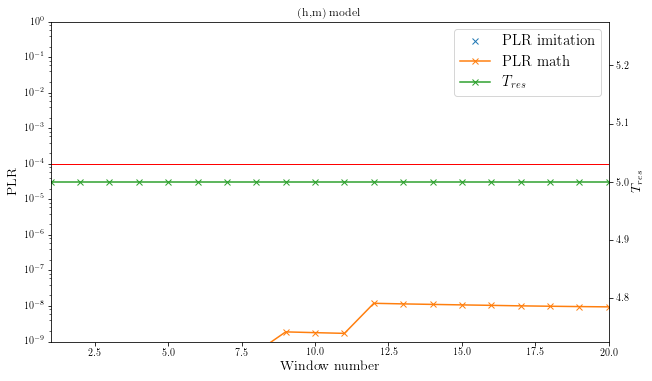

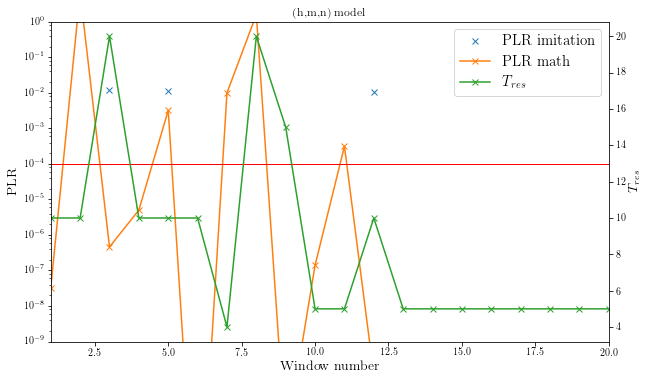

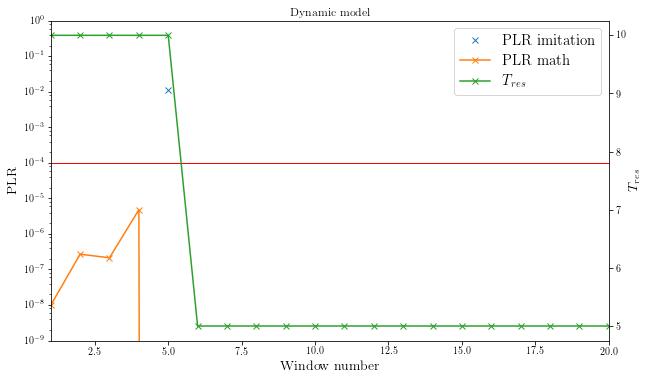

In [182]:
%matplotlib inline
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
import matplotlib.pyplot as plt

window_number = [i + 1 for i in range(number_of_windows)]
n_plots = len(results)
for n_plot, (label, (ana_plrs, sim_plrs, res_periods)) in enumerate(results.items()):
    ana_plrs = ana_plrs[::-1]
    ana_plrs.pop()
    ana_plrs = ana_plrs[::-1]
    plt.figure(figsize=(10, 20))
    ax1 = host_subplot(n_plots, 1, n_plot + 1)
    ax2 = ax1.twinx()
    ax1.set_xlabel("Window number", color='k')
    ax1.set_ylabel("PLR", color='k')
    ax2.set_ylabel("$T_{res}$", color='k')
    
    p_sim, = ax1.plot(window_number, sim_plrs, linestyle='none', label="PLR imitation", marker='x')
    p_ana, = ax1.plot(window_number, ana_plrs, label="PLR math", marker='x')
    p_Tres, = ax2.plot(window_number, res_periods, label="$T_{res}$", marker='x')

    leg = ax1.legend()

    """host.yaxis.get_label().set_color(p_sim.get_color())
    leg.texts[0].set_color(p_sim.get_color())

    par.yaxis.get_label().set_color(p_ana.get_color())
    leg.texts[1].set_color(p_ana.get_color())

    host.yaxis.get_label().set_color(p_Tres.get_color())
    leg.texts[2].set_color(p_Tres.get_color())"""

    ax1.set_yscale('log')
    ax1.set_xlim(window_number[0], window_number[len(window_number) - 1])
    ax1.set_ylim(1e-9, 1)
    ax1.axhline(target_plr, color='red', lw=1)
    ax1.set_title(label + ' model')
    #fig = ax.savefig(model_name + '.Dallas.test.png', format='png', dpi = 1000)
    plt.show()
    #plt.clf()